# HW 9 - Investigating Chaotic systems with python


## Excercise 1

Recall the Holling-Tanner Model of an ecological system

*Plants*  
$\dot{x} = x(1-x) - \frac{a_1x}{1+b_1x}y$  

*Herbivores*  
$\dot{y} = \frac{a_1x}{1+b_1x}y - d_1y-\frac{a_2y}{1+b_2y}z$  

*Carnivores*  
$\dot{z} = \frac{a_2y}{1+b_2y}z - d_2z$


Simulate these equations for at least two sets of initial conditions that are less than 1% apart using the following parameters  
`a1 = 5`  
`b1 = 3`  
`a2 = 0.1`  
`b2 = 2`  
`d1 = 0.4`  
`d2 = 0.01`  

Plot the results as both a time series and trajectories. What eventually happens to the trajectories?

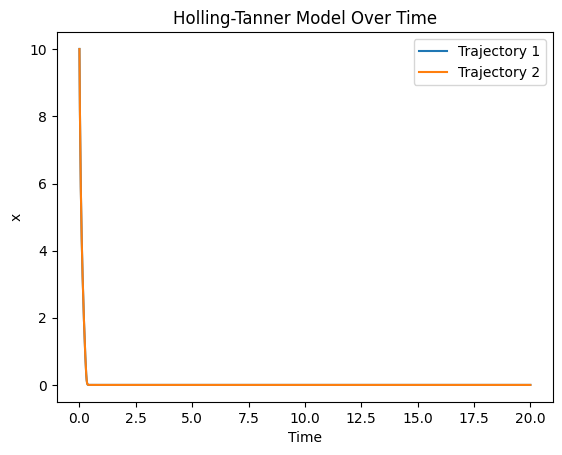

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define Holling-Tanner system
def HT(state, t0, a1 = 5, a2 = 0.1, b1 = 3, b2 = 2, d1 = 0.4, d2 = 0.01):

    # unpack state variables
    x = state[0]
    y = state[1]
    z = state[2]

    # H-T equations
    dxdt = x * (1 - x) - ((a1 * x)/(1 + (b1 * x))) * y
    dydt = (((a1 * x)/(1 + (b1 * x))) * y) - (d1 * y) - ((a2 * y)/(1 + (b2 * y))) * z
    dzdt = (((a2 * y)/(1 + (b2 * y))) * z) - (d2 * z)

    return [dxdt, dydt, dzdt]

N_trajectories = 2
t = np.linspace(0, 20, 1000)
initial_conditions = [10 + 0.01 * np.random.random(3) for i in range(N_trajectories)]
states = []
for i in range(N_trajectories):
    state = odeint(HT, initial_conditions[i], t)
    states.append(state)

plt.plot(t, states[0][:, 0])
plt.plot(t, states[1][:, 0])

plt.legend(('Trajectory 1', 'Trajectory 2'))
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Holling-Tanner Model Over Time')
plt.show()


## Excercise 2
Recall that the concept of "sensitivity to initial conditions" can be given a precise definition.

Suppose $m_0$ and $n_0$ are two sets of initial conditions for the Holling-Tanner system and $d(m_0,n_0)$ is the distance between those points.

In the Holling-Tanner system $m_0$ and $n_0$ are points in 3-dimensional space, so the distance between them can be calculated using the standard formula for Euclidean distance:

$d(m,n) = \sqrt{(x_m-x_n)^2+(y_m-y_n)^2+(z_m-z_n)^2}$

After time $t$ the points $m_0$ and $n_0$ have been integrated to $m_t$ and $n_t$. Sensitivity dependance says that $d(m_t, n_t)$ grows exponentially with time with different levels of sensitivity being associated with different values of the lyapunov exponentn $\lambda$, such that  

$d(m_t, n_t) = e^{\lambda t}d(m_0,n_0)$  

Approximate the lyapunov exponent for the Holling-Tanner system using the parameters from Excercise 1. Show your work. 

## Excercise 3

Plot the Lorenz Map of the herbivores in the Holling-Tanner system using the abovementioned parameters.  

What happens at an Nth peak height of ~0.29? What does it represent?



## Excercise 4 (Extra Credit)
Demonstrate and explain why chaos can only occur in a 3D system. 
Show what you would have to do to the FitzHugh Nagumo System to bring it into a chaotic regime.
What are the tradeoffs between for an open system that must be functional (e.g. something in biology) in being almost but not quite chaotic as it approaches a parameter set that gives a lyapunov coefficient greater than 0.

Who did you work with: